# Modelado en Optimización (IIND-2501)

## Lección 3.2: Optimización en problemas de estimación

In [1]:
'''
Importaciones y configuraciones generales del notebook. No modificar.
'''
from helpers_estimacion import init_estimacion, ejemplo_ilustrativo, ajuste_manual, fit_ols, metrics_ols, plot_ols

np, plt, urlopen, pd, widgets, display = init_estimacion()

### 1 - Formular un problema de estimación

Creamos un dataset sencillo con una sola variable para poder visualizar el comportamiento de los métodos de optimización que resuelven problemas de aprendizaje (más adelante usaremos un dataset real). *Suponemos* una variable $y$ cuyo comportamiento se relaciona con otra variable $x$ de forma lineal. Por ejemplo, en determinado sector, el salario de una persona ($y$) puede depender *linealmente* de sus años de experiencia ($x$). 

$$\mathbf{y} = a + b\mathbf{x}$$

Con suficientes observaciones, podemos determinar si esto en efecto se cumple, y cuál sería la recta que nos ayuda a explicar o predecir los salarios en este sector a partir de los años de experiencia de un aspirante (i.e., qué valores de $a$ y $b$ generan buenas estimaciones de $y$ a partir de $x$).

In [2]:
datos, true_coefs = ejemplo_ilustrativo() 
datos.head()

,Años de experiencia (x),Salario normalizado (y)
0,7.5,39.0
1,19.0,87.0
2,14.6,65.1
3,12.0,55.3
4,3.1,17.2


In [3]:
n = datos.shape[0]
y = datos["Salario normalizado (y)"]
x = datos["Años de experiencia (x)"]
X = np.vstack([np.ones(n), x]).T        # extiende con columna de 1s (coeficientes del término independente a)

a_true, b_true = true_coefs

In [4]:
ajuste_manual(x, y)

interactive(children=(FloatSlider(value=1.0, description='Pendiente', max=10.0, min=-10.0), FloatSlider(value=…

Output()

### 2 - Cómo medir qué tan bueno es el modelo de estimación

Para valores dados ($a'$ y $b'$) de los coeficientes, podemos hacer una estimación $\hat{y}$ dado un $x$.

$$\hat{y}=a' + b' x$$

La distancia entre $\hat{y}$ y el $y$ real de las observaciones nos da una idea de qué tan buena es la estimación lineal que logran $a'$ y $b'$. Queremos los valores de $a$ y $b$ que minimizan esa distancia, comunmente medida a través del *Error Medio Cuadrático* (MSE) o algunas variaciones.

$$MSE = f(a,b) = \frac{1}{N}\sum_{i=1}^{N}[ y_i-\hat{y}_i ]^2$$

$$MSE = f(a,b)  = \frac{1}{N}\sum_{i=1}^{N}[y_i-(a+b x_i)]^2 $$

Es decir, queremos la recta que se ajusta más cercanamente a las observaciones disponibles, así que formulamos el siguiente problema de optimización: *¿qué valores de a y b minimizan el MSE?*.

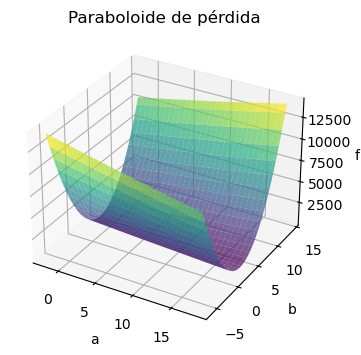

In [5]:
def mse(beta0, beta1):
    beta = np.array([beta0, beta1])
    res = y - X @ beta
    return (res @ res) / n  # multiplicar vector de residuos por si mismo da errores cuadráticos

b0 = np.linspace(a_true-10, a_true+10, 60)
b1 = np.linspace(b_true-10, b_true+10, 60)
B0, B1 = np.meshgrid(b0, b1)
J = np.vectorize(mse)(B0, B1)     # Función J recibe b0,b1, retorna MSE 

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(B0, B1, J, cmap='viridis', alpha=0.7)
ax.set_xlabel('a'); ax.set_ylabel('b'); ax.set_zlabel('f')
plt.title('Paraboloide de pérdida'); plt.show()

### 3 – Solución iterativa mediante *descenso de gradiente*

Para la misma $J(\beta)$, su gradiente es
$$\nabla J(\beta) = -\frac{2}{n} X^\top (y - X\beta).$$

Partiremos de un punto arbitrario $x_0$ y aplicaremos la ecuación de actualización de movimiento, usando siempre como dirección el gradiente negativo en el punto (i.e., $\Delta x = \nabla J(\beta)$), y variando diferentes tamaños de paso $\alpha$.

$$\mathbf{x}^{t+1} = \mathbf{x}^t + \alpha \Delta \mathbf{x}$$

In [6]:
def gradient_descent(X, y, alpha=0.001, max_iter=5000, tol=1e-6):
    n, p = X.shape
    beta = np.ones(p)           # iniciamos suponiendo [a,b]=[b0,b1]=[1,1] e iteramos
    traj_beta = [beta.copy()]   # acumula histórico variables
    traj_J = []                 # acumula histórico objetivo
    for it in range(max_iter):
        res = y - X @ beta
        grad = -(2/n) * X.T @ res
        beta_new = beta - alpha * grad
        traj_beta.append(beta_new.copy())
        traj_J.append((res @ res)/n)
        if np.linalg.norm(beta_new - beta) < tol:
            break
        beta = beta_new
    return beta, np.array(traj_beta), traj_J

beta_gd, traj_b, traj_J = gradient_descent(X, y)
print('Coeficientes según gradiente:', beta_gd)

Coeficientes según gradiente: [7.0456 4.091 ]


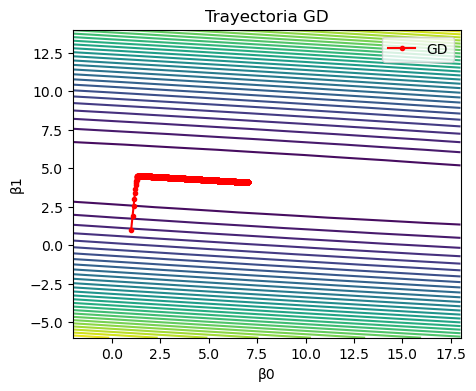

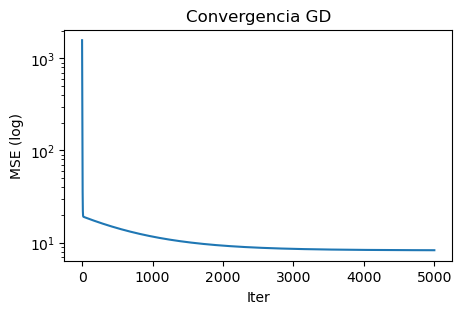

In [7]:
plt.figure(figsize=(5,4))
plt.contour(B0, B1, J, levels=30, cmap='viridis')
plt.plot(traj_b[:,0], traj_b[:,1], 'r.-', label='GD')
#plt.scatter(beta_closed[0], beta_closed[1], c='black', label='closed‑form')
plt.xlabel('β0'); plt.ylabel('β1'); plt.title('Trayectoria GD'); plt.legend(); plt.show()

plt.figure(figsize=(5,3))
plt.plot(traj_J); plt.yscale('log')
plt.xlabel('Iter'); plt.ylabel('MSE (log)'); plt.title('Convergencia GD'); plt.show()

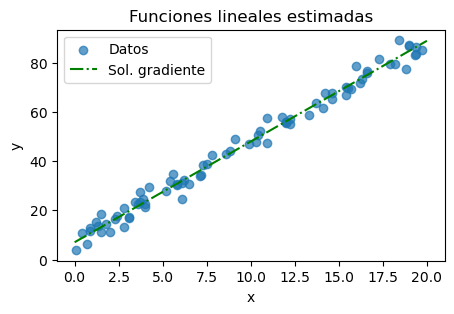

In [8]:
def plot_regression(x, y, beta_gd):
    plt.figure(figsize=(5,3))
    plt.scatter(x, y, alpha=0.7, label='Datos')
    xs = np.linspace(0, 20, 100)    
    plt.plot(xs, beta_gd[0] + beta_gd[1]*xs, '-.', color='g', label='Sol. gradiente')
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Funciones lineales estimadas')
    plt.show()

plot_regression(x, y, beta_gd)

### 4 - Ejemplo con datos reales (regresión lineal)

#### Estimar costo de viviendas a partir del ingreso mediano

Usaremos el caso *California Housing* disponible en la librería scikit-learn de Python. La intuición general es que barrios con **mayor ingreso mediano** tienden a tener **viviendas más costosas**.

Usaremos dos de las variables del *dataset*:
- $x$: ingreso mediano del bloque (en decenas de miles USD)
- $y$: valor mediano de vivienda (en centenas de miles USD)

In [9]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = data.frame.rename(columns=str)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
# Variables: x = ingreso mediano del bloque (en decenas de miles USD), y = valor mediano de vivienda (en centenas de miles USD)
x = df["MedInc"].values
y = df["MedHouseVal"].values

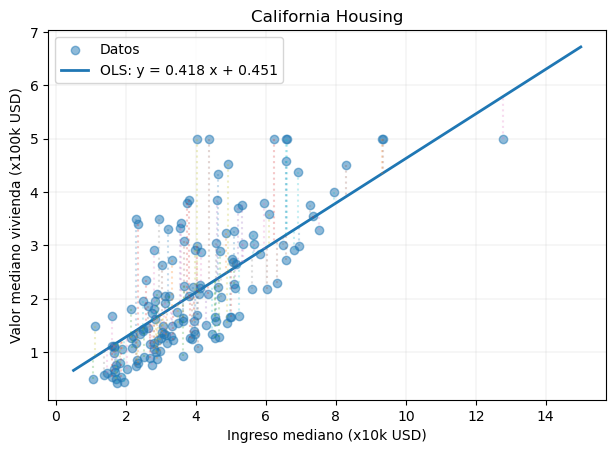

In [11]:
# --- Visualización con residuos (solucionada internamente con el paquete numpy)
plot_ols(
    x, y,
    title="California Housing",
    xlabel="Ingreso mediano (x10k USD)",
    ylabel="Valor mediano vivienda (x100k USD)",
)

#### Ejercicio:

Encontrar los parámetros (b,m) que minimizan el MSE para el ejemplo de **California Housing** utilizando la implementación del algoritmo de gradiente presentada arriba:

In [12]:
'''
Escribe aquí tu solución:
 - Define función de pérdida
 - Calcula el gradiente
 - Aplica el algoritmo de descenso por gradiente 
'''



'\nEscribe aquí tu solución:\n - Define función de pérdida\n - Calcula el gradiente\n - Aplica el algoritmo de descenso por gradiente \n'

### Apéndice – Solución analítica mediante álgebra lineal

De manera general, se le llama $\theta$ o $\beta$ al vector que agrupa los coeficientes de la relación lineal entre $x$ y $y$ (es decir, los coeficiente $a$ y $b$, y otros cuando se incluyen más variables). Así, con $\mathbf{\beta}=[\beta_0, \beta_1]$, tendríamos:

$$y = \beta_0 + \beta_1 x$$

Y de manera general, $y = \mathbf{\beta}X$. Una manera formal de escribir algebraicamente el MSE es a través de la norma del vector diferencia entre el $y$ real y el $y$ estimado ($\mathbf{\beta}X$):

$$J(\beta) = \|y - X\beta\|_2^2$$

Por tratarse de una función cuadrática (convexa), sabemos que el mínimo estará en el punto donde "la derivada" se hace cero, lo cual se extiende al concepto de gradiente y se conoce como *condiciones de primer orden* (el óptimo deberá cumplir $\nabla J = 0$):

$$ -2X^\top(y - X\beta)=0$$
$$ (X^\top X)\beta = X^\top y$$
$$\hat\beta=(X^\top X)^{-1}X^\top y$$

#### Solución analítica para el ejemplo ilustrativo (salario VS años de experiencia)

In [13]:
beta_closed = np.linalg.inv(X.T @ X) @ (X.T @ y)
print('Valores estimados analíticamente\n [a,b] = [beta_0, beta_1] =', beta_closed)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20640 is different from 80)

#### Ejercicio:
Calcula de manera analítica los coeficientes para el caso de California y compara contra la solución obtenida por descenso de graiente.